# MODEL 1: ALS Estimator Using Spark

### Step 1 : Set up the environment / necessary housekeeping

In [328]:
#!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz

!pip install -q findspark
#!pip install pyspark

# Set up required environment variables
import os
os.environ["JAVA_HOME"] = "/Library/Java/JavaVirtualMachines/jdk1.8.0_251.jdk/Contents/Home"
os.environ["SPARK_HOME"] = "spark-2.4.5-bin-hadoop2.7"

!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

!java -version
!python --version

/usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java has not been configured as an alternative for java
openjdk version "1.8.0_152-release"
OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12)
OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
Python 3.6.5 :: Anaconda, Inc.


In [329]:
#install spark
import pyspark
 # get a spark context
sc = pyspark.SparkContext.getOrCreate()
print(sc)
# get a spark session
spark = pyspark.sql.SparkSession.builder.getOrCreate()
print(spark)
spark.version

<SparkContext master=local[*] appName=pyspark-shell>


'2.3.2'

In [316]:
import findspark
findspark.init("spark-2.4.5-bin-hadoop2.7")

### Step 2 : Load data

In [331]:
#download the relevant dataset directly from grouplens
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
#unzip the movielens zip file
!unzip -o ml-latest-small.zip

--2020-04-19 23:07:05--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip.1’

ml-latest-small.zip 100%[===================>] 955.28K  --.-KB/s    in 0.1s    

2020-04-19 23:07:06 (6.25 MB/s) - ‘ml-latest-small.zip.1’ saved [978202/978202]

Archive:  ml-latest-small.zip
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [334]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import *
import pandas as pd
# the imports are used creating the data frame

# create a SparkSession
spark = SparkSession.builder.getOrCreate()  

data_movie=pd.read_csv("ml-latest-small/movies.csv")
df_movie=spark.createDataFrame(data_movie)
df_movie.show()

data_ratings=pd.read_csv("ml-latest-small/ratings.csv")
df_ratings=spark.createDataFrame(data_ratings)
df_ratings.show()

data_tags=pd.read_csv("ml-latest-small/tags.csv")
df_tags=spark.createDataFrame(data_tags)
df_tags.show()

df_ratings.createOrReplaceTempView('ratings') 
df_movie.createOrReplaceTempView('movie') 
df_tags.createOrReplaceTempView('tags') 

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [335]:
# split into test and training set
(training, test) = df_ratings.randomSplit([0.8, 0.2]) 
#show columns of training dataset
training.printSchema() 
#show the size of training and test dataset
print(training.count()) 
print(test.count())

root
 |-- userId: long (nullable = true)
 |-- movieId: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)

80613
20223


### Step 3 : Create a baseline

In [336]:
#get the average rating and show the result
SQL1 = 'SELECT AVG(rating) FROM ratings'
row = spark.sql(SQL1).collect()[0] 

#access Row as a map 
meanRating = row['avg(rating)'] 
print('meanRating',meanRating)

#get the se as rdd
se_rdd = test.rdd.map(lambda row: Row(se = pow(row['rating']-meanRating,2)) ) 
se_df = spark.createDataFrame(se_rdd) 
se_df.createOrReplaceTempView('se')
print('se_df',se_df)

#calculate the average se as rmse
SQL2 = 'SELECT AVG(se) FROM se'
row = spark.sql(SQL2).collect()[0]
meanSE = row['avg(se)'] # access Row as a map 
print('RMSE',pow(meanSE,0.5))

meanRating 3.501556983616962
se_df DataFrame[se: double]
RMSE 1.0443961226898368


### Step 4 : train ALS estimator and perform cross validation

In [337]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

# Build the recommendation model using ALS on the training data
als = ALS(maxIter=3, rank=10, regParam=0.1, userCol="userId", itemCol="movieId", ratingCol="rating",coldStartStrategy="drop")

#Set the parameter grid
paramGrid = ParamGridBuilder() \
  .addGrid(als.regParam, [0.03,0.1,0.3]) \
  .addGrid(als.rank, [3,10,30]).build()

regEval = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

#Start the cross validation and fit on the training dataset 
crossVal = CrossValidator(estimator=als, estimatorParamMaps=paramGrid, evaluator=regEval)
cvModel = crossVal.fit(training)

In [338]:
# Show the metrics form the CrossValidation
print(cvModel.avgMetrics) 

# Gives us the parameter combinations
print(cvModel.getEstimatorParamMaps()) 
paramMap = list(zip(cvModel.getEstimatorParamMaps(),cvModel.avgMetrics))

# Print the parameter that gives us the smallest rmse
paramMin = min(paramMap, key=lambda x: x[1])
print(paramMin)

[1.041380346886138, 1.133822371199086, 1.2141167632341814, 0.9565144434135651, 0.9684671237354774, 0.9523983148459281, 0.9478279129730727, 0.9526930601550425, 0.9614873279002033]
[{Param(parent='ALS_4a3bb822613163031abc', name='regParam', doc='regularization parameter (>= 0).'): 0.03, Param(parent='ALS_4a3bb822613163031abc', name='rank', doc='rank of the factorization'): 3}, {Param(parent='ALS_4a3bb822613163031abc', name='regParam', doc='regularization parameter (>= 0).'): 0.03, Param(parent='ALS_4a3bb822613163031abc', name='rank', doc='rank of the factorization'): 10}, {Param(parent='ALS_4a3bb822613163031abc', name='regParam', doc='regularization parameter (>= 0).'): 0.03, Param(parent='ALS_4a3bb822613163031abc', name='rank', doc='rank of the factorization'): 30}, {Param(parent='ALS_4a3bb822613163031abc', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='ALS_4a3bb822613163031abc', name='rank', doc='rank of the factorization'): 3}, {Param(parent='ALS_4a3bb822

In [347]:
#Implement the als model with the best parameter
als = ALS(maxIter=3, rank=3, regParam=0.3, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(training)

In [348]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("RMSE = " + str(rmse))

RMSE = 0.9197193709700572


In [349]:
#Get the prediction result
predictions.show()
predictions.createOrReplaceTempView('predictions') 

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   409|    471|   3.0| 967912821| 3.5213432|
|   599|    471|   2.5|1498518822|  2.613184|
|   603|    471|   4.0| 954482443|  3.045631|
|   176|    471|   5.0| 840109075|  3.758057|
|   260|    471|   4.5|1109409455| 3.3274763|
|   492|    833|   4.0| 863976674| 1.8482109|
|   159|   1088|   4.0|1508641161| 2.7212946|
|   599|   1088|   2.5|1498515232|    2.5214|
|   177|   1088|   3.5|1435534616| 3.0498457|
|   132|   1088|   4.0|1329984080| 2.6493483|
|    64|   1088|   4.0|1161559902| 3.3072796|
|   286|   1088|   3.5|1119561544| 3.2374957|
|    51|   1088|   4.0|1230929736| 3.4875898|
|   385|   1238|   3.0| 865026050| 3.8254848|
|   325|   1238|   4.0|1039399025| 4.1811686|
|    19|   1238|   3.0| 965705784| 3.2632127|
|   469|   1238|   5.0| 965425364|  4.269255|
|   503|   1342|   1.0|1335214611| 2.5141034|
|   322|   1580|   3.5|1217676294|

### Step 5 : Movie recommendation results

In [373]:
# Get top 5 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
userRecs.show()
# Get top 5 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   471|[[40491, 5.672796...|
|   463|[[40491, 5.954995...|
|   496|[[40491, 4.975547...|
|   148|[[40491, 5.718086...|
|   540|[[40491, 6.123964...|
|   392|[[69211, 5.144297...|
|   243|[[40491, 7.202004...|
|    31|[[40491, 6.270772...|
|   516|[[127152, 5.66693...|
|   580|[[40491, 5.532756...|
|   251|[[40491, 6.504772...|
|   451|[[40491, 6.073125...|
|    85|[[40491, 5.530024...|
|   137|[[127152, 5.31616...|
|    65|[[40491, 5.882410...|
|   458|[[40491, 6.898907...|
|   481|[[112804, 4.70933...|
|    53|[[40491, 7.733330...|
|   255|[[40491, 3.893648...|
|   588|[[40491, 5.020005...|
+------+--------------------+
only showing top 20 rows



In [358]:
# Get top 5 movie recommendations for a specified set of users
users = ratings.select(als.getUserCol()).distinct().limit(3)
userSubsetRecs = model.recommendForUserSubset(users, 5)

# Get top 10 user recommendations for a specified set of movies
movies = ratings.select(als.getItemCol()).distinct().limit(3)
movieSubSetRecs = model.recommendForItemSubset(movies, 5)

### Step 6 : Try to predict for a specific user (other approach)

In [374]:
#for a specific userid like 471
#get the history rating record of userid 471
user_history = df_ratings.filter(df_ratings['userId']==471)
user_history.count()

28

In [375]:
# show a list of movies we are considering to offer for userid 471
user_suggest = test.filter(training['userId']==471).select(['movieId', 'userId'])
user_suggest.show()

+-------+------+
|movieId|userId|
+-------+------+
|   2571|   471|
|   4886|   471|
|   4973|   471|
|   8636|   471|
|   8961|   471|
|  44191|   471|
| 158966|   471|
+-------+------+



In [377]:
# offer movies with high predicted ratings
user_offer = model.transform(user_suggest)
user_offer.orderBy('prediction', ascending=False).show()

+-------+------+----------+
|movieId|userId|prediction|
+-------+------+----------+
| 158966|   471| 4.7567644|
|   4973|   471|  3.859761|
|   2571|   471| 3.8219507|
|  44191|   471| 3.6086144|
|   8961|   471|  3.584847|
|   4886|   471|  3.576926|
|   8636|   471| 3.5584917|
+-------+------+----------+



In [378]:
#get final recommendation result for each user
training.createOrReplaceTempView('training') 
df_movie.createOrReplaceTempView('movies') 

#sql query to join relevant tables
rec_table = '''SELECT C.userId,predictions.movieId,C.maxpred FROM predictions,
        (SELECT MAX(prediction) AS maxpred,userId FROM predictions WHERE userId IN (SELECT userId FROM training) GROUP BY userId) C
        WHERE predictions.prediction=C.maxpred'''
spark.sql(rec_table).createOrReplaceTempView('rec_table') 

#add movie titles to the final table
rec_with_title='''SELECT P.userId,P.movieId,M.title,P.maxpred 
                FROM rec_table P,movies M WHERE M.movieId=P.movieId
                ORDER BY P.userId ASC '''
spark.sql(rec_with_title).show()
spark.sql(rec_with_title).createOrReplaceTempView('rec_table_with_title') 


+------+-------+--------------------+---------+
|userId|movieId|               title|  maxpred|
+------+-------+--------------------+---------+
|     1|   1927|All Quiet on the ...|4.7764473|
|     2|    318|Shawshank Redempt...|4.3135047|
|     3|   7991|Death Race 2000 (...|1.8482091|
|     4|   1199|       Brazil (1985)| 3.719996|
|     5|    296| Pulp Fiction (1994)|3.7526035|
|     6|     50|Usual Suspects, T...|4.0304146|
|     7|   2858|American Beauty (...| 3.386016|
|     8|    364|Lion King, The (1...| 3.694403|
|     9|    922|Sunset Blvd. (a.k...| 4.041396|
|    10| 119145|Kingsman: The Sec...|3.3264163|
|    11|    318|Shawshank Redempt...| 4.545095|
|    12|   4018|What Women Want (...|3.7311437|
|    13|     47|Seven (a.k.a. Se7...|3.8527455|
|    14|    296| Pulp Fiction (1994)|3.5292988|
|    15|   5618|Spirited Away (Se...|3.5562706|
|    16|   1223|Grand Day Out wit...|3.7746477|
|    17|   4226|      Memento (2000)| 4.157515|
|    18|  71899| Mary and Max (2009)| 4.

In [246]:
#spark.sql('SELECT * FROM rec_table_with_title WHERE userId IN (11,314,184,198,163,710,881,504,267,653)').show()

+------+-------+--------------------+---------+
|userId|movieId|               title|  maxpred|
+------+-------+--------------------+---------+
|    11|    593|Silence of the La...| 4.205923|
|   163|   1608|Air Force One (1997)| 2.728574|
|   184| 176371|Blade Runner 2049...| 3.325054|
|   198|   1274|        Akira (1988)|3.8723414|
|   267|    260|Star Wars: Episod...|4.4245963|
|   314|    318|Shawshank Redempt...|3.4993153|
|   504|    296| Pulp Fiction (1994)| 4.139361|
+------+-------+--------------------+---------+



# Model 2 : Content-based Movie Recommendation

In [399]:
#importing the required libraries
import numpy as np
import pickle
!pip install scipy
import matrix_factorization_utilities
import scipy.sparse as sp
from scipy.sparse.linalg import svds

OSError: [Errno 12] Cannot allocate memory

In [393]:
#transform the dataset into pandas dataframe
tag=df_tags.toPandas()
movie=df_movie.toPandas()
ratings=df_ratings.toPandas()

# Model 2: AWS SageMaker Factorization Machines 

In [89]:
#environment setting
bucket = 'movierecom'
prefix = 'sagemaker/movielens'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [269]:
#data ingestion
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -o ml-100k.zip

--2020-04-13 21:12:13--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  13.5MB/s    in 0.3s    

2020-04-13 21:12:13 (13.5 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [270]:
#data inspection
%cd ml-100k
!shuf ua.base -o ua.base.shuffled
!head -10 ua.base.shuffled
!head -10 ua.test

/home/ec2-user/SageMaker/ml-100k/ml-latest-small/ml-100k/ml-latest-small/ml-100k
348	476	4	886523735
896	482	3	887158359
810	876	3	886614969
468	293	5	875280395
13	820	4	882398743
907	202	5	880160204
279	804	4	875744416
407	1028	3	876348832
778	216	3	890726264
65	393	4	879217881
1	20	4	887431883
1	33	4	878542699
1	61	4	878542420
1	117	3	874965739
1	155	2	878542201
1	160	4	875072547
1	171	5	889751711
1	189	3	888732928
1	202	5	875072442
1	265	4	878542441


In [271]:
import pandas as pd
data = pd.read_csv("ua.base.shuffled", sep='\t', header=None, names=['userid', 'movieid', 'rating', 'timestamp'])

nbUsers = data['userid'].max()
nbMovies = data['movieid'].max()
nbFeatures = nbUsers + nbMovies
print("Number of Users: %d" % nbUsers)
print("Number of Movies: %d" % nbMovies)
print("Number of Features: %d" % nbFeatures)

Number of Users: 943
Number of Movies: 1682
Number of Features: 2625


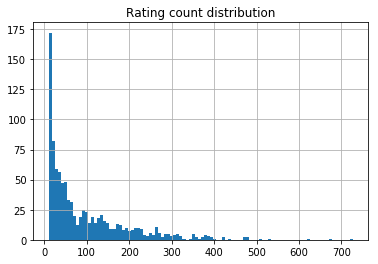

In [275]:
import matplotlib. pyplot as plt
movies_by_user = data.groupby('userid')
res = movies_by_user['movieid'].count().hist(bins=100)
res.set_title('Rating count distribution')
res
plt.show()

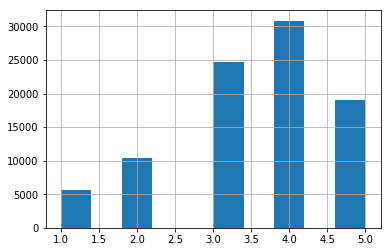

In [276]:
data['rating'].hist()

In [277]:
nbRatingsTrain = 90570
nbRatingsTest = 9430

In [278]:
import csv
import numpy as np
from scipy.sparse import lil_matrix

# For each user, build a list of rated movies.
# We'd need this to add random negative samples.
moviesByUser = {}
for userId in range(nbUsers):
    moviesByUser[str(userId)] = []
 
with open('ua.base.shuffled', 'r') as f:
    samples = csv.reader(f, delimiter = '\t')
    for userId, movieId, rating, timestamp in samples:
        moviesByUser[str(int(userId) - 1)].append(int(movieId) - 1)

In [279]:
def loadDataset(filename, lines, columns):
    # Features are one-hot encoded in a sparse matrix
    X = lil_matrix((lines, columns)).astype('float32')
    # Labels are stored in a vector
    Y = []
    line = 0
    with open(filename, 'r') as f:
        samples = csv.reader(f, delimiter = '\t')
        for userId, movieId, rating, timestamp in samples:
            X[line, int(userId) - 1] = 1
            X[line, int(nbUsers) + int(movieId)-1] = 1
            if int(rating) >= 4:
                Y.append(1)
            else:
                Y.append(0)
            line = line + 1
            
    Y = np.array(Y).astype('float32')
    return X, Y

In [280]:
X_train, Y_train = loadDataset('ua.base.shuffled', nbRatingsTrain, nbFeatures)
X_test, Y_test = loadDataset('ua.test', nbRatingsTest, nbFeatures)

In [281]:

print(X_train.shape)
print(Y_train.shape)
assert X_train.shape == (nbRatingsTrain, nbFeatures)
assert Y_train.shape == (nbRatingsTrain, )
zero_labels = np.count_nonzero(Y_train)
print("Training labels: %d zeros, %d ones" % (zero_labels, nbRatingsTrain-zero_labels))

print(X_test.shape)
print(Y_test.shape)
assert X_test.shape  == (nbRatingsTest, nbFeatures)
assert Y_test.shape  == (nbRatingsTest, )
zero_labels = np.count_nonzero(Y_test)
print("Test labels: %d zeros, %d ones" % (zero_labels, nbRatingsTest-zero_labels))

(90570, 2625)
(90570,)
Training labels: 49906 zeros, 40664 ones
(9430, 2625)
(9430,)
Test labels: 5469 zeros, 3961 ones


In [ ]:
#upload training data

In [282]:
train_key      = 'train.protobuf'
train_prefix   = '{}/{}'.format(prefix, 'train')

test_key       = 'test.protobuf'
test_prefix    = '{}/{}'.format(prefix, 'test')

output_location  = 's3://{}/{}/output'.format(bucket, prefix)

In [283]:

import sagemaker.amazon.common as smac
import io

def writeDatasetToProtobuf(X, Y, bucket, prefix, key):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, Y)
    buf.seek(0)
    obj = '{}/{}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket,obj)
    
train_data = writeDatasetToProtobuf(X_train, Y_train, bucket, train_prefix, train_key)    
test_data  = writeDatasetToProtobuf(X_test, Y_test, bucket, test_prefix, test_key)    

print('uploaded training data location: {}'.format(train_data))
print('uploaded test data location: {}'.format(test_data))
print('training artifacts will be uploaded to: {}'.format(output_location))

uploaded training data location: s3://movierecom/sagemaker/movielens/train/train.protobuf
uploaded test data location: s3://movierecom/sagemaker/movielens/test/test.protobuf
training artifacts will be uploaded to: s3://movierecom/sagemaker/movielens/output


In [284]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'factorization-machines')

In [285]:

import sagemaker

sess = sagemaker.Session()

fm = sagemaker.estimator.Estimator(container,
                                   role, 
                                   train_instance_count=1, 
                                   train_instance_type='ml.t2.medium',
                                   output_path=output_location,
                                   sagemaker_session=sess)

fm.set_hyperparameters(feature_dim=nbFeatures,
                      predictor_type='binary_classifier',
                      mini_batch_size=1000,
                      num_factors=64,
                      epochs=100)

fm.fit({'train': train_data, 'test': test_data})

2020-04-13 21:18:05 Starting - Starting the training job...
2020-04-13 21:18:06 Starting - Launching requested ML instances......
2020-04-13 21:19:32 Starting - Preparing the instances for training......
2020-04-13 21:20:25 Downloading - Downloading input data
2020-04-13 21:20:25 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python2.7/site-packages/pandas/util/nosetester.py:13: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing import nosetester
[04/13/2020 21:20:40 INFO 139641748956992] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'factors_lr': u'0.0001', u'linear_init_sigma': u'0.01', u'epochs': 1, u'_wd': u'1.0', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'factors_init_sigma': u'0.001', u'_log_level': u'info', u'bias_

[04/13/2020 21:20:43 INFO 139641748956992] #quality_metric: host=algo-1, epoch=4, batch=0 train binary_classification_accuracy <score>=0.723
[04/13/2020 21:20:43 INFO 139641748956992] #quality_metric: host=algo-1, epoch=4, batch=0 train binary_classification_cross_entropy <loss>=0.649062255859
[04/13/2020 21:20:43 INFO 139641748956992] #quality_metric: host=algo-1, epoch=4, batch=0 train binary_f_1.000 <score>=0.783085356304
[2020-04-13 21:20:43.620] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 10, "duration": 530, "num_examples": 91, "num_bytes": 5796480}
[04/13/2020 21:20:43 INFO 139641748956992] #quality_metric: host=algo-1, epoch=4, train binary_classification_accuracy <score>=0.65621978022
[04/13/2020 21:20:43 INFO 139641748956992] #quality_metric: host=algo-1, epoch=4, train binary_classification_cross_entropy <loss>=0.647317964994
[04/13/2020 21:20:43 INFO 139641748956992] #quality_metric: host=algo-1, epoch=4, train binary_f_1.000 <score>


2020-04-13 21:20:39 Training - Training image download completed. Training in progress.[2020-04-13 21:20:53.533] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 50, "duration": 494, "num_examples": 91, "num_bytes": 5796480}
[04/13/2020 21:20:53 INFO 139641748956992] #quality_metric: host=algo-1, epoch=24, train binary_classification_accuracy <score>=0.730043956044
[04/13/2020 21:20:53 INFO 139641748956992] #quality_metric: host=algo-1, epoch=24, train binary_classification_cross_entropy <loss>=0.567030813364
[04/13/2020 21:20:53 INFO 139641748956992] #quality_metric: host=algo-1, epoch=24, train binary_f_1.000 <score>=0.768420060332
#metrics {"Metrics": {"update.time": {"count": 1, "max": 495.82815170288086, "sum": 495.82815170288086, "min": 495.82815170288086}}, "EndTime": 1586812853.533883, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1586812853.03749}

[04/13/2020 21:20:53 INFO 13

[2020-04-13 21:21:03.284] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 90, "duration": 482, "num_examples": 91, "num_bytes": 5796480}
[04/13/2020 21:21:03 INFO 139641748956992] #quality_metric: host=algo-1, epoch=44, train binary_classification_accuracy <score>=0.741549450549
[04/13/2020 21:21:03 INFO 139641748956992] #quality_metric: host=algo-1, epoch=44, train binary_classification_cross_entropy <loss>=0.541488186679
[04/13/2020 21:21:03 INFO 139641748956992] #quality_metric: host=algo-1, epoch=44, train binary_f_1.000 <score>=0.7736620762
#metrics {"Metrics": {"update.time": {"count": 1, "max": 483.597993850708, "sum": 483.597993850708, "min": 483.597993850708}}, "EndTime": 1586812863.285354, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1586812862.801181}

[04/13/2020 21:21:03 INFO 139641748956992] #progress_metric: host=algo-1, completed 45 % of epochs
#metrics {"Metrics": {"M

[2020-04-13 21:21:13.174] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 130, "duration": 481, "num_examples": 91, "num_bytes": 5796480}
[04/13/2020 21:21:13 INFO 139641748956992] #quality_metric: host=algo-1, epoch=64, train binary_classification_accuracy <score>=0.745307692308
[04/13/2020 21:21:13 INFO 139641748956992] #quality_metric: host=algo-1, epoch=64, train binary_classification_cross_entropy <loss>=0.527643878979
[04/13/2020 21:21:13 INFO 139641748956992] #quality_metric: host=algo-1, epoch=64, train binary_f_1.000 <score>=0.775957234966
#metrics {"Metrics": {"update.time": {"count": 1, "max": 482.94782638549805, "sum": 482.94782638549805, "min": 482.94782638549805}}, "EndTime": 1586812873.174477, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1586812872.690964}

[04/13/2020 21:21:13 INFO 139641748956992] #progress_metric: host=algo-1, completed 65 % of epochs
#metrics {"Metr


2020-04-13 21:21:35 Uploading - Uploading generated training model[2020-04-13 21:21:23.404] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 172, "duration": 491, "num_examples": 91, "num_bytes": 5796480}
[04/13/2020 21:21:23 INFO 139641748956992] #quality_metric: host=algo-1, epoch=85, train binary_classification_accuracy <score>=0.748285714286
[04/13/2020 21:21:23 INFO 139641748956992] #quality_metric: host=algo-1, epoch=85, train binary_classification_cross_entropy <loss>=0.518184666896
[04/13/2020 21:21:23 INFO 139641748956992] #quality_metric: host=algo-1, epoch=85, train binary_f_1.000 <score>=0.778351912061
#metrics {"Metrics": {"update.time": {"count": 1, "max": 492.8910732269287, "sum": 492.8910732269287, "min": 492.8910732269287}}, "EndTime": 1586812883.404915, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1586812882.911451}

[04/13/2020 21:21:23 INFO 139641748956992] #progre


2020-04-13 21:21:42 Completed - Training job completed
Training seconds: 93
Billable seconds: 93


In [286]:
#set up hosting for the model

In [287]:
fm_predictor = fm.deploy(initial_instance_count=1,
                         instance_type='ml.t2.medium')

-------------!

In [ ]:
#validate the model for use

In [288]:
import json
from sagemaker.predictor import json_deserializer

def fm_serializer(data):
    js = {'instances': []}
    for row in data:
        js['instances'].append({'features': row.tolist()})
    return json.dumps(js)

fm_predictor.content_type = 'application/json'
fm_predictor.serializer = fm_serializer
fm_predictor.deserializer = json_deserializer

In [289]:
prediction = X_test[1000].toarray()
result = fm_predictor.predict(prediction)

print(Y_test[1000])
print(result)

0.0
{'predictions': [{'score': 0.6547636389732361, 'predicted_label': 1.0}]}


In [290]:
import numpy as np

predictions = []
for array in np.array_split(X_test[1000:1100].toarray(), 1):
    result = fm_predictor.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]

predictions = np.array(predictions)

In [291]:
import pandas as pd

pd.crosstab(Y_test[1000:1100], predictions, rownames=['actuals'], colnames=['predictions'])

predictions,0.0,1.0
actuals,,
0.0,45,16
1.0,21,18


In [297]:
predictions.shape

(100,)

In [298]:
#(Optional) Delete the Endpoint
import sagemaker

sagemaker.Session().delete_endpoint(fm_predictor.endpoint)